<a href="https://colab.research.google.com/github/RMottram/2D-CNN/blob/master/2d_cnn_fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sys, os, time, csv, cv2

import sklearn
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Convolution1D, Convolution2D, MaxPooling2D, Flatten, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

# from ann_visualizer.visualize import ann_viz

# Settings
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision = 5, suppress = True)

# CNN Binary output

## 1.1 - Import the dataset

In [ ]:
CUR_DIR = os.getcwd()

train_master = pd.read_csv(CUR_DIR + '/KDDTrain+.csv')
test_master = pd.read_csv(CUR_DIR + '/KDDTest+.csv')

In [3]:
edited_train = train_master.copy()
edited_test = test_master.copy()

## 1.2 - Create the dataframes

In [4]:
edited_train = edited_train.drop(['difficulty_lvl'], axis = 1)
edited_test = edited_test.drop(['difficulty_lvl'], axis = 1)

### Removes some types of services to even out datasets

In [5]:
edited_train = edited_train.query("service != 'aol'")
edited_train = edited_train.query("service != 'harvest'")
edited_train = edited_train.query("service != 'http_2784'")
edited_train = edited_train.query("service != 'http_8001'")
edited_train = edited_train.query("service != 'red_i'")
edited_train = edited_train.query("service != 'urh_i'")
edited_train = edited_train.query("service != 'printer'")
edited_train = edited_train.query("service != 'rje'")

edited_test = edited_test.query("service != 'printer'")
edited_test = edited_test.query("service != 'rje'")

## 1.3 - Change 'non normal' entries to 'attack'

In [6]:
edited_train.loc[edited_train.attack_type != 'normal', 'attack_type'] = 'attack'
edited_test.loc[edited_test.attack_type != 'normal', 'attack_type'] = 'attack'

In [7]:
edited_train

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,150,25,0.17000,0.03000,0.17000,0.00000,0.00000,0.00000,0.05000,0.00000,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.00000,0.00000,0.00000,0.00000,0.08000,0.15000,0.00000,255,1,0.00000,0.60000,0.88000,0.00000,0.00000,0.00000,0.00000,0.00000,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.00000,1.00000,0.00000,0.00000,0.05000,0.07000,0.00000,255,26,0.10000,0.05000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,attack
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.20000,0.20000,0.00000,0.00000,1.00000,0.00000,0.00000,30,255,1.00000,0.00000,0.03000,0.04000,0.03000,0.01000,0.00000,0.01000,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.09000,255,255,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,184,25,1.00000,1.00000,0.00000,0.00000,0.14000,0.06000,0.00000,255,25,0.10000,0.06000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,attack
125969,8,udp,private,SF,105,145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,255,244,0.96000,0.01000,0.01000,0.00000,0.00000,0.00000,0.00000,0.00000,normal
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,255,30,0.12000,0.06000,0.00000,0.00000,0.72000,0.00000,0.01000,0.00000,normal
125971,0,tcp,klogin,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,144,8,1.00000,1.00000,0.00000,0.00000,0.06000,0.05000,0.00000,255,8,0.03000,0.05000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,attack


## 1.4 - Encode protocol, service and flag features

In [8]:
proto_ohe_train = pd.get_dummies(edited_train['protocol_type'])
proto_ohe_test = pd.get_dummies(edited_test['protocol_type'])

service_ohe_train = pd.get_dummies(edited_train['service'])
service_ohe_test = pd.get_dummies(edited_test['service'])

flag_ohe_train = pd.get_dummies(edited_train['flag'])
flag_ohe_test = pd.get_dummies(edited_test['flag'])

## 1.5 - Replace original features with the OHE features

In [9]:
edited_train = edited_train.drop(['protocol_type', 'service', 'flag'], axis = 1)
edited_test = edited_test.drop(['protocol_type', 'service', 'flag'], axis = 1)

xtrain = pd.concat([edited_train, proto_ohe_train, service_ohe_train, flag_ohe_train], axis = 1)
xtest = pd.concat([edited_test, proto_ohe_test, service_ohe_test, flag_ohe_test], axis = 1)

In [10]:
for column in xtrain:
    # xtrain[column] = xtrain[column] / xtrain[column].max()
    
    if xtrain[column].isna().any():
        xtrain[column] = float(0)

for column in xtest:
    # xtest[column] = xtest[column] / xtest[column].max()
    
    if xtest[column].isna().any():
        xtest[column] = float(0)

In [11]:
edited_xtrain = xtrain.copy()
edited_xtest = xtest.copy()

In [13]:
edited_xtrain = edited_xtrain.drop(['attack_type'], axis = 1)
edited_xtest = edited_xtest.drop(['attack_type'], axis = 1)

edited_xtrain

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,icmp,tcp,udp,IRC,X11,Z39_50,auth,bgp,courier,csnet_ns,ctf,daytime,discard,domain,domain_u,echo,eco_i,ecr_i,efs,exec,finger,ftp,ftp_data,gopher,hostnames,http,http_443,imap4,iso_tsap,klogin,kshell,ldap,link,login,mtp,name,netbios_dgm,netbios_ns,netbios_ssn,netstat,nnsp,nntp,ntp_u,other,pm_dump,pop_2,pop_3,private,remote_job,shell,smtp,sql_net,ssh,sunrpc,supdup,systat,telnet,tftp_u,tim_i,time,urp_i,uucp,uucp_path,vmnet,whois,OTH,REJ,RSTO,RSTOS0,RSTR,S0,S1,S2,S3,SF,SH
0,0,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,150,25,0.17000,0.03000,0.17000,0.00000,0.00000,0.00000,0.05000,0.00000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.00000,0.00000,0.00000,0.00000,0.08000,0.15000,0.00000,255,1,0.00000,0.60000,0.88000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.00000,1.00000,0.00000,0.00000,0.05000,0.07000,0.00000,255,26,0.10000,0.05000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.20000,0.20000,0.00000,0.00000,1.00000,0.00000,0.00000,30,255,1.00000,0.00000,0.03000,0.04000,0.03000,0.01000,0.00000,0.01000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.09000,255,255,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,184,25,1.00000,1.00000,0.00000,0.00000,0.14000,0.06000,0.00000,255,25,0.10000,0.06000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
125969,8,105,145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,255,244,0.96000,0.01000,0.01000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
125970,0,2231,384,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,255,30,0.12000,0.06000,0.00000,0.00000,0.72000,0.00000,0.01000,0.00000,0,1,0,0,0,0,0

In [14]:
edited_xtrain.max(numeric_only = True).sum()

2689960916.0

In [15]:
edited_xtrain = 255 * edited_xtrain / edited_xtrain.max(numeric_only = True)

edited_xtrain

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,icmp,tcp,udp,IRC,X11,Z39_50,auth,bgp,courier,csnet_ns,ctf,daytime,discard,domain,domain_u,echo,eco_i,ecr_i,efs,exec,finger,ftp,ftp_data,gopher,hostnames,http,http_443,imap4,iso_tsap,klogin,kshell,ldap,link,login,mtp,name,netbios_dgm,netbios_ns,netbios_ssn,netstat,nnsp,nntp,ntp_u,other,pm_dump,pop_2,pop_3,private,remote_job,shell,smtp,sql_net,ssh,sunrpc,supdup,systat,telnet,tftp_u,tim_i,time,urp_i,uucp,uucp_path,vmnet,whois,OTH,REJ,RSTO,RSTOS0,RSTR,S0,S1,S2,S3,SF,SH
0,0.00000,0.00009,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,0.00000,0.00000,0.99804,0.99804,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,150.00000,25.00000,43.35000,7.65000,43.35000,0.00000,0.00000,0.00000,12.75000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000
1,0.00000,0.00003,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,0.00000,0.00000,6.48728,0.49902,0.00000,0.00000,0.00000,0.00000,20.40000,38.25000,0.00000,255.00000,1.00000,0.00000,153.00000,224.40000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000
2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,0.00000,0.00000,61.37965,2.99413,255.00000,255.00000,0.00000,0.00000,12.75000,17.85000,0.00000,255.00000,26.00000,25.50000,12.75000,0.00000,0.00000,255.00000,255.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,0.00000,0.00004,0.00159,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,0.00000,0.00000,2.49511,2.49511,51.

In [16]:
edited_xtest = 255 * edited_xtest / edited_xtest.max(numeric_only = True)

edited_xtest

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,icmp,tcp,udp,IRC,X11,Z39_50,auth,bgp,courier,csnet_ns,ctf,daytime,discard,domain,domain_u,echo,eco_i,ecr_i,efs,exec,finger,ftp,ftp_data,gopher,hostnames,http,http_443,imap4,iso_tsap,klogin,kshell,ldap,link,login,mtp,name,netbios_dgm,netbios_ns,netbios_ssn,netstat,nnsp,nntp,ntp_u,other,pm_dump,pop_2,pop_3,private,remote_job,shell,smtp,sql_net,ssh,sunrpc,supdup,systat,telnet,tftp_u,tim_i,time,urp_i,uucp,uucp_path,vmnet,whois,OTH,REJ,RSTO,RSTOS0,RSTR,S0,S1,S2,S3,SF,SH
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,0.00000,0.00000,114.27593,4.99022,0.00000,0.00000,255.00000,255.00000,10.20000,15.30000,0.00000,255.00000,10.00000,10.20000,15.30000,0.00000,0.00000,0.00000,0.00000,255.00000,255.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,0.00000,0.00000,67.86693,0.49902,0.00000,0.00000,255.00000,255.00000,2.55000,15.30000,0.00000,255.00000,1.00000,0.00000,15.30000,0.00000,0.00000,0.00000,0.00000,255.00000,255.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,0.00884,0.05270,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,0.00000,0.00000,0.49902,0.49902,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,134.00000,86.00000,155.55000,10.20000,155.55000,5.10000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000
3,0.00000,0.00008,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,0.00000,0.00000,0.49902,32.43

In [17]:
edited_xtrain['attack_type'] = xtrain['attack_type'].values

edited_xtrain

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,icmp,tcp,udp,IRC,X11,Z39_50,auth,bgp,courier,csnet_ns,ctf,daytime,discard,domain,domain_u,echo,eco_i,ecr_i,efs,exec,finger,ftp,ftp_data,gopher,hostnames,http,http_443,imap4,iso_tsap,klogin,kshell,ldap,link,login,mtp,name,netbios_dgm,netbios_ns,netbios_ssn,netstat,nnsp,nntp,ntp_u,other,pm_dump,pop_2,pop_3,private,remote_job,shell,smtp,sql_net,ssh,sunrpc,supdup,systat,telnet,tftp_u,tim_i,time,urp_i,uucp,uucp_path,vmnet,whois,OTH,REJ,RSTO,RSTOS0,RSTR,S0,S1,S2,S3,SF,SH,attack_type
0,0.00000,0.00009,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,0.00000,0.00000,0.99804,0.99804,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,150.00000,25.00000,43.35000,7.65000,43.35000,0.00000,0.00000,0.00000,12.75000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,normal
1,0.00000,0.00003,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,0.00000,0.00000,6.48728,0.49902,0.00000,0.00000,0.00000,0.00000,20.40000,38.25000,0.00000,255.00000,1.00000,0.00000,153.00000,224.40000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,normal
2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,0.00000,0.00000,61.37965,2.99413,255.00000,255.00000,0.00000,0.00000,12.75000,17.85000,0.00000,255.00000,26.00000,25.50000,12.75000,0.00000,0.00000,255.00000,255.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,attack
3,0.00000,0.00004,0.00159,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,0.

In [18]:
edited_xtest['attack_type'] = xtest['attack_type'].values

edited_xtest

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,icmp,tcp,udp,IRC,X11,Z39_50,auth,bgp,courier,csnet_ns,ctf,daytime,discard,domain,domain_u,echo,eco_i,ecr_i,efs,exec,finger,ftp,ftp_data,gopher,hostnames,http,http_443,imap4,iso_tsap,klogin,kshell,ldap,link,login,mtp,name,netbios_dgm,netbios_ns,netbios_ssn,netstat,nnsp,nntp,ntp_u,other,pm_dump,pop_2,pop_3,private,remote_job,shell,smtp,sql_net,ssh,sunrpc,supdup,systat,telnet,tftp_u,tim_i,time,urp_i,uucp,uucp_path,vmnet,whois,OTH,REJ,RSTO,RSTOS0,RSTR,S0,S1,S2,S3,SF,SH,attack_type
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,0.00000,0.00000,114.27593,4.99022,0.00000,0.00000,255.00000,255.00000,10.20000,15.30000,0.00000,255.00000,10.00000,10.20000,15.30000,0.00000,0.00000,0.00000,0.00000,255.00000,255.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,attack
1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,0.00000,0.00000,67.86693,0.49902,0.00000,0.00000,255.00000,255.00000,2.55000,15.30000,0.00000,255.00000,1.00000,0.00000,15.30000,0.00000,0.00000,0.00000,0.00000,255.00000,255.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,attack
2,0.00884,0.05270,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,0.00000,0.00000,0.49902,0.49902,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,134.00000,86.00000,155.55000,10.20000,155.55000,5.10000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,normal
3,0.00000,0.00008,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,

In [19]:
for column in edited_xtrain:
    # edited_xtrain[column] = xtrain[column] / xtrain[column].max()
    
    if edited_xtrain[column].isna().any():
        edited_xtrain[column] = float(0)

for column in edited_xtest:
    # edited_xtest[column] = xtest[column] / xtest[column].max()
    
    if edited_xtest[column].isna().any():
        edited_xtest[column] = float(0)

In [20]:
normal_imgs_train = edited_xtrain[(edited_train['attack_type'] == 'normal')]
attack_imgs_train = edited_xtrain[(edited_train['attack_type'] == 'attack')]

normal_imgs_test = edited_xtest[(edited_test['attack_type'] == 'normal')]
attack_imgs_test = edited_xtest[(edited_test['attack_type'] == 'attack')]


## encode the attack_type column OHE
ytrain = pd.get_dummies(edited_train['attack_type'])
ytest = pd.get_dummies(edited_test['attack_type'])

## drop the columns after encoding
# xtrain = train.drop(['attack_type'], axis = 1)
# xtest = test.drop(['attack_type'], axis = 1)

normal_imgs_train = normal_imgs_train.drop(['attack_type'], axis = 1)
attack_imgs_train = attack_imgs_train.drop(['attack_type'], axis = 1)

normal_imgs_test = normal_imgs_test.drop(['attack_type'], axis = 1)
attack_imgs_test = attack_imgs_test.drop(['attack_type'], axis = 1)

## 1.6 - Histogram equalisation on raw data

### Transforming the dataframe to numpy array then reshape to 64x64 images

In [21]:
normal_imgs_train = normal_imgs_train.to_numpy()
normal_imgs_train = np.ravel(normal_imgs_train, order = 'F')
normal_imgs_train.shape

(7675050,)

In [22]:
normal_imgs_test = normal_imgs_test.to_numpy()
normal_imgs_test = np.ravel(normal_imgs_test, order = 'F')
normal_imgs_test.shape

(1107054,)

In [23]:
attack_imgs_train = attack_imgs_train.to_numpy()
attack_imgs_train = np.ravel(attack_imgs_train, order = 'F')
attack_imgs_train.shape

(6665352,)

In [24]:
attack_imgs_test = attack_imgs_test.to_numpy()
attack_imgs_test = np.ravel(attack_imgs_test, order = 'F')
attack_imgs_test.shape

(1460796,)

### training

In [25]:
attack_padding = -attack_imgs_train.size % 4096
normal_padding = -normal_imgs_train.size % 4096

if attack_padding:
    attack_imgs_train = np.concatenate((attack_imgs_train,
                                        np.zeros(attack_padding, dtype = attack_imgs_train.dtype)))

if normal_padding:
    normal_imgs_train = np.concatenate((normal_imgs_train,
                                        np.zeros(normal_padding, dtype = normal_imgs_train.dtype)))

In [26]:
normal_imgs_tr = normal_imgs_train.reshape(-1, 64, 64, 1)
attack_imgs_tr = attack_imgs_train.reshape(-1, 64, 64, 1)

normal_imgs_tr.shape, attack_imgs_tr.shape

((1874, 64, 64, 1), (1628, 64, 64, 1))

### testing

In [27]:
attack_padding = -attack_imgs_test.size % 4096
normal_padding = -normal_imgs_test.size % 4096

if attack_padding:
    attack_imgs_test = np.concatenate((attack_imgs_test,
                                        np.zeros(attack_padding, dtype = attack_imgs_test.dtype)))

if normal_padding:
    normal_imgs_test = np.concatenate((normal_imgs_test,
                                        np.zeros(normal_padding, dtype = normal_imgs_test.dtype)))

In [28]:
normal_imgs_te = normal_imgs_test.reshape(-1, 64, 64, 1)
attack_imgs_te = attack_imgs_test.reshape(-1, 64, 64, 1)

normal_imgs_te.shape, attack_imgs_te.shape

((271, 64, 64, 1), (357, 64, 64, 1))

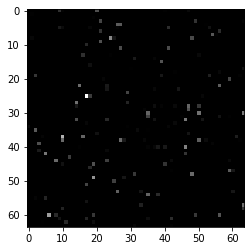

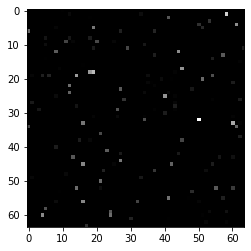

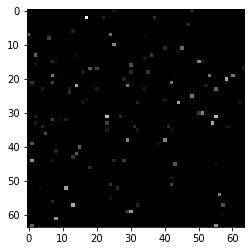

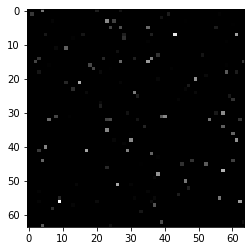

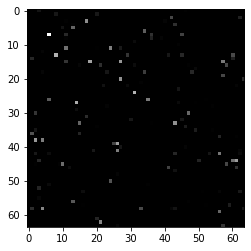

In [32]:
for t in range(0, 5):
    plt.imshow(normal_imgs_tr[t], cmap = 'gray')
    plt.show()
    
    # cv2.imwrite(CUR_DIR + f'/image_before_equ_{t}.bmp', normal_imgs_tr[t])

In [34]:
for t in range(0, 50):
  img_b = cv2.imread(f'image_before_equ_{t}.jpg', 0)
  equ = cv2.equalizeHist(img_b)
  # res = np.hstack((img_b,equ))
  img_a = cv2.imwrite(f'image_after_equ_{t}.jpg', equ)
  # img_a_out = cv2.imread('image_after.jpg', 0)

# img_b2 = cv2.imread('image_before_equ.png', 0)
# equ2 = cv2.equalizeHist(img_b2)
# # res = np.hstack((img_b,equ))
# img_a2 = cv2.imwrite('image_after_equ.png', equ2)
# # img_a_out2 = cv2.imread('image_after.png', 0)

# img_b3 = cv2.imread('image_before_equ.bmp', 0)
# equ3 = cv2.equalizeHist(img_b3)
# # res = np.hstack((img_b,equ))
# img_a3 = cv2.imwrite('image_after_equ.bmp', equ3)
# # img_a_out3 = cv2.imread('image_after.bmp', 0)

In [60]:
# os.chdir('/Users/ryan/NSL CNN/2d-cnn/64x64')
# new_dir = os.mkdir('test_normal')
path = '/Users/ryan/NSL CNN/2d-cnn/64x64/test_attack'

In [61]:
## create the before images

for t in range(0, len(attack_imgs_te)):
#     plt.imshow(normal_imgs[t], cmap = 'gray')
#     plt.show()
    
    cv2.imwrite(os.path.join(path, f'image_before_{t}.jpg'), attack_imgs_te[t])
#     cv2.imwrite(f'image_before_{t}.bmp', normal_imgs[t])

In [65]:
## loop through the before images, perform equalisation and save images to same directory
## ensure CWD is the directory saving the images to

for file in os.listdir(path):
    for i in range(0, attack_imgs_te.shape[0]):
        pre_equ = cv2.imread(f'image_before_{i}.jpg', 0)
        # print(file)
        equalised = cv2.equalizeHist(pre_equ)
        cv2.imwrite(f'equ_image_{i}.jpg', equalised)

In [64]:
path

'/Users/ryan/NSL CNN/2d-cnn/64x64/test_attack'

In [63]:
os.getcwd()

'/Users/ryan/NSL CNN/2d-cnn/64x64/test_attack'

In [62]:
os.chdir('/Users/ryan/NSL CNN/2d-cnn/64x64/test_attack')

In [ ]:
# normal_imgs_train = 255 * normal_imgs_train/normal_imgs_train.max()

In [ ]:
# normal_imgs_train.max(), normal_imgs_train.min(), normal_imgs_train.mean()

(255.0, 0.0, 0.00045024836605361585)

In [ ]:
train_max = normal_imgs_train.max() + attack_imgs_train.max()

train_max

1469545408.0